# HOTVis: Implementation

## To Do
- gucken, an welchen Stellen mans beschleunigen kann 
    - evtl zweite schleife wie Fruchtermann Reingold für Dense Matrix
- Algo mit Graphen aus Paper testen

## Imports

In [17]:
import torch
import pathpyG as pp

## Übergabeparameter

In [18]:

# nur hier zum testen
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4), ('a', 'b', 4), ('c', 'b', 4),
              ('c', 'd', 5), ('b', 'a', 5), ('c', 'b', 6), ('e', 'f', 1), ('f', 'e', 1), ('e', 'f', 2), ('f', 'e', 2), 
              ('e', 'f', 3), ('f', 'e', 3), ('e', 'f', 4), ('f', 'e', 4)]

# mandatory
graph = pp.TemporalGraph.from_edge_list(tedges)
K = 2
N = 100
delta = 1
alpha = [0.5, 0.5]

# optional
force = 1
positions = torch.rand((graph.N, 2))
# nur hier zum testen
initial_positions = positions
seed = 0

## Initialisierung

In [19]:

A = torch.zeros((graph.N, graph.N))
# the initial "temperature"  is about .1 of domain area (=1x1)
# this is the largest step allowed in the dynamics.
t = 0.1  #max(max(positions.T[0]) - min(positions.T[0]), max(positions.T[1]) - min(positions.T[1])) * 0.1
# simple cooling scheme.
# linearly step down by dt on each iteration so last iteration is size dt.
dt = t / float(N + 1)

## Erste Schleife

Vektorisierung:

Wir benötigen folgende Informationen: Für die Kante $((v_0, ..., v_{k-1}), (v_1,...,v_k))$ eines Higher Order Graphen müssen wir für unseren Algorithmus die Knoten $v_0$ und $v_k$ herausfinden. Bis auf die Benennung der Knoten gibt es keine Datenstruktur wie z.B. eine Adjazenzmatrix in dem Higher Order Graphen, die diese Information direkt oder indirekt beinhaltet. Dadurch müssen wir die Bennenung jeder einzelnen Kante angucken und somit über alle einzelnen Kanten iterieren .

In [20]:
mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=K)
# iterate over higher orders
for i in range(K):
    ho_graph = mo_model.layers[i+1]
    # iterate over edges of higher order graph
    for edge in ho_graph.edges:
        # for edge ((v_0, ..., v_{k-1}), (v_1,...,v_k)) get nodes v_0 and v_k
        # for i == 0, edge has form (v_0, v_1)
        if(i == 0):
            node_start = edge[0]
            node_end = edge[1]
        # for i > 0, edge has form ((v_0, ..., v_{i-1}), (v_1,...,v_i))
        else:
            node_start = edge[0][0]
            node_end = edge[1][-1]

        # get indices of the nodes
        index_node_start = graph.mapping.to_idx(node_start)
        index_node_end = graph.mapping.to_idx(node_end)

         # TEST
        if(index_node_start==1 and index_node_end==1):
            test = 1

        # add to A
        A[index_node_start, index_node_end] += alpha[i] * ho_graph['edge_weight', edge[0], edge[1]]
    
print(A)
A_first_loop = A

100%|██████████| 6/6 [00:00<00:00, 117.29it/s]


tensor([[1.0000, 1.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.5000, 2.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 1.5000]])


### Alternative 1. Schleife

In [21]:
# reinitialise
A = torch.zeros((graph.N, graph.N))
mo_model = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=K)

for i in range(K):
    ho_graph = mo_model.layers[i+1]
    
    nodes_start = list(map(lambda x: x[0], ho_graph.edges))
    nodes_end = list(map(lambda x: x[1], ho_graph.edges))

    if(i > 0):
        nodes_start = list(map(lambda x: x[0], nodes_start))
        nodes_end = list(map(lambda x: x[-1], nodes_end))

    nodes_start = list(map(lambda x: graph.mapping.to_idx(x), nodes_start))
    nodes_end = list(map(lambda x: graph.mapping.to_idx(x), nodes_end))

    nodes_start = torch.tensor(nodes_start)
    nodes_end = torch.tensor(nodes_end)

    edge_weights = ho_graph['edge_weight']# müsste das selbe wie unten sein

    # Problem: kommt ein paar zweimal vor, wird der wert trotzdem nur einmal aufaddiert
    A[nodes_start, nodes_end] += alpha[i] * edge_weights

A_second_loop = A

100%|██████████| 6/6 [00:00<00:00, 239.80it/s]


In [22]:
print(A_second_loop == A_first_loop)
print(A_first_loop)
print(A_second_loop)

tensor([[ True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True]])
tensor([[1.0000, 1.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.5000, 2.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000, 1.5000]])
tensor([[1.0000, 1.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 1.0000, 0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.5000, 2.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 2.0000,

## Zweite Schleife

In [23]:
# names of variables here vs in paper
    # displacement = theta
    # length = |theta|
    # delta = delta
    # distance = |delta|
    # force = k

# every nodes "movement" or displacement gets describet by an tuple (x, y) 
displacement = torch.zeros((graph.N, 2))
for iteration in range(N):
    # reset displacement
    displacement *= 0
    # loop over rows/nodes
    for i in range(A.shape[0]):
        # difference between this row's node position and all others
        delta = positions - positions[i]
        # distance between the nodes
        distance = torch.sqrt((delta**2).sum(dim=1))
        # enforce minimum distance of 0.01
        distance = torch.where(distance < 0.01, 0.01, distance)
        # calculate displacement of node i
        displacement[i] += (delta/distance.view(-1,1) * (A[i] * distance**2 / force -  force**2 / distance).view(-1,1)).sum(dim=0)
    # get length of displacement
    length = torch.sqrt((displacement**2).sum(dim=1))
    # enforce minimum length of 0.01
    length = torch.where(length < 0.01, 0.1, length)
    # add temperature
    length_with_temp = torch.clamp(length, max=t)
    # update positions
    positions += displacement / length.view(-1,1) * length_with_temp.view(-1,1)
    # cool temperature
    t -= dt

positions_first_loop = positions

###  Alternative 2. Schleife

In [24]:
# only now for testing: reinitialize
positions = initial_positions
t=0.1

delta = torch.zeros((positions.shape[0], positions.shape[0], positions.shape[1]))
# the inscrutable (but fast) version
for iteration in pp.tqdm(range(N)):
    # matrix of difference between points
    delta = positions[torch.newaxis, :, :] - positions[:, torch.newaxis, :]#tauschen?
    # distance between points
    distance = torch.linalg.norm(delta, dim=-1)
    # enforce minimum distance of 0.01
    torch.clip(distance, 0.01, None, out=distance)
    # calculate displacement of all nodes
    displacement = torch.einsum('ijk,ij->ik',
                            delta,
                            ( A * distance / force - force**2 / distance**2))
    # calculate length of displacements
    length = torch.linalg.norm(displacement, dim=-1)
    # enforce minimum length of 0.01
    length = torch.where(length < 0.01, 0.1, length)
    # add temperature
    length_with_temp = torch.clamp(length, max=t)
    # calculate the change of the postionions
    delta_positions = torch.einsum('ij,i->ij', displacement, length_with_temp / length)
    # update positions
    positions += delta_positions
    # cool temperature
    t -= dt
   
positions_second_loop = positions



## Berechnung der Verschiebung aller Knoten

Die Verschiebung (`displacement`) wird mithilfe eines Einsum-Produkts berechnet:

```python
displacement = torch.einsum('ijk,ij->ik', delta, 
                            (A * distance / force - force**2 / distance**2))
```

### Definition von (`delta`)

`delta` ist definiert als eine 3D-Matrix der Form:

`delta` = 
\begin{bmatrix}
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[1] \\
    \text{pos}[2] - \text{pos}[1] \\
    \text{pos}[3] - \text{pos}[1] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[1] \\
  \end{bmatrix}
  & 
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[2] \\
    \text{pos}[2] - \text{pos}[2] \\
    \text{pos}[3] - \text{pos}[2] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[2] \\
  \end{bmatrix}
  &
  \cdots
  &
  \begin{bmatrix}
    \text{pos}[1] - \text{pos}[n] \\
    \text{pos}[2] - \text{pos}[n] \\
    \text{pos}[3] - \text{pos}[n] \\
    \vdots \\
    \text{pos}[n] - \text{pos}[n] \\
  \end{bmatrix}
\end{bmatrix}

Jeder hier dargestellte Block berechnet sich dabei durch ```positions - positions[i]```

### Form des 3. Parameters

Der Ausdruck

$\text{A} \cdot \frac{\text{distance}}{\text{force}} - \frac{\text{force}^2}{\text{distance}^2}$

ist eine $n \times n$-Matrix.

### Elementweise Multiplikation

Beide Werte aller $j$ Zeilen der $j \times k$-Blöcke ($i$ stück) aus ```delta```, berechnet durch ```positions - positions[i]```, werden mit dem jeweiligen Wert aus ```A[i, j]``` elementweise multipliziert. Danach wird über den Index ```j``` summiert, also über die Zeilen der Blöcke.

## Berechnung der Änderung der Positionen

Die Änderung der Positionen wird berechnet durch:

```python
delta_positions = torch.einsum('ij,ij->ij', displacement, length_with_temp / length)
```

```delta_positions``` ist eine $ n \times 2 $-Matrix. Die $x$- und $y$-Koordinaten jeder Verschiebung werden mit dem entsprechenden Skalar aus der $n \times 1$-Matrix $\frac{\text{length\_with\_temp}}{\text{length}}$ multipliziert.



## Plot

a
b
c
d
e
f
{'a': [-5.314183712005615, 6.67336368560791], 'b': [-5.930084228515625, 5.946898937225342], 'c': [-4.533502101898193, 5.749594688415527], 'd': [-2.692155361175537, 5.397101879119873], 'e': [-1.9502782821655273, -8.877910614013672], 'f': [-1.3009891510009766, -9.336868286132812]}


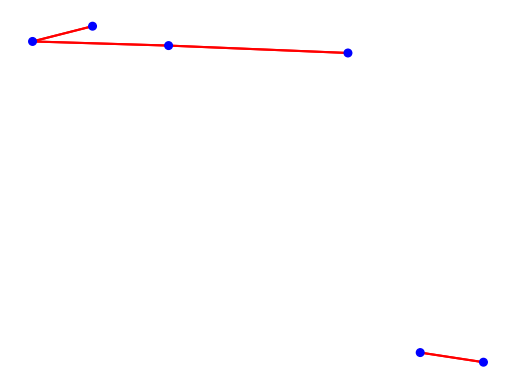

In [25]:
layout = {}
for node in graph.nodes:
    print(node)
    layout[node] = positions_first_loop[graph.mapping.to_idx(node)].tolist()
print(layout)    
pp.plot(mo_model.layers[1], backend='matplotlib', layout=layout)

a
b
c
d
e
f
{'a': [-5.314183712005615, 6.67336368560791], 'b': [-5.930084228515625, 5.946898937225342], 'c': [-4.533502101898193, 5.749594688415527], 'd': [-2.692155361175537, 5.397101879119873], 'e': [-1.9502782821655273, -8.877910614013672], 'f': [-1.3009891510009766, -9.336868286132812]}


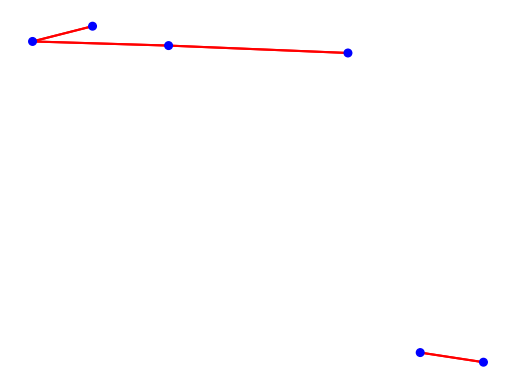

In [26]:
layout = {}
for node in graph.nodes:
    print(node)
    layout[node] = positions_second_loop[graph.mapping.to_idx(node)].tolist()
print(layout)    
pp.plot(mo_model.layers[1], backend='matplotlib', layout=layout)